<a href="https://colab.research.google.com/github/YashvanthD/SED/blob/master/Preparing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install pyaudio
!pip install json-tricks

In [ ]:
import pandas as pd
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn
import time

In [ ]:
folder_path =r"./data"


tic = time.perf_counter()

# Other DATA SET
def find_emotion_T(name): 
        
        if('neutral' in name or 'NEU' in name): return "01"
        elif('happy' in name or 'HAP' in name): return "03"
        elif('sad' in name or 'SAD' in name): return "04"
        elif('angry' in name or 'ANG' in name): return "05"
        elif('fear' in name or 'FEA' in name): return "06"
        elif('disgust' in name or 'DIS' in name): return "07"
        elif('ps' in name): return "08"
        elif(len(name)==10):
            if(name[3]=='a'): return "05"
            elif(name[3]=='d'): return "07"
            elif(name[3]=='f'): return "06"
            elif(name[3]=='h'): return "03"
            elif(name[3]=='n'): return "01"
        elif(len(name)==11):
            # print(name[3:5],len(name))
            if('sa'== name[3:5]): return "04"
            elif('su'== name[3:5]): return "08" 
        
        else: 
            return "-1"
        
# RAVADEES
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

sample_lengths = []

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 
        x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
        xt, index = librosa.effects.trim(x, top_db=30)
    #     print(sample_lengths     )
        sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))    


rms = []
zcr = []
mfcc = []
emotions = []

total_length = np.max(sample_lengths) 
frame_length = 2048
hop_length = 512
features_lenght=total_length//hop_length

for subdir, dirs, files in os.walk(folder_path):
    for file in files: 
        try:
            _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
        # Load the audio file.
            # print(file)
            rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 

        # Normalize the audio to +5.0 dBFS.
            normalizedsound = effects.normalize(rawsound, headroom = 0) 

        # Transform the normalized audio to np.array of samples.
            normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

        # Trim silence from the beginning and the end.
            xt, index = librosa.effects.trim(y=normal_x, top_db=30)

        # Pad for duration equalization.
            padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')

        # Noise reduction.
            final_x = nr.reduce_noise(y=padded_x, sr=sr)

       # Features extraction 
            f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
            f2 = librosa.feature.zero_crossing_rate(y=final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
            f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC


            if (find_emotion_T(file) != "-1"): #GET DATA database validation
                name = find_emotion_T(file)
            else:                              #RAVDESS database validation
                name = file[6:8]                      

            rms.append(f1)
            zcr.append(f2)
            mfcc.append(f3)
            emotions.append(emotionfix(name))
            
        except Exception as e:
            # print(f1[0][:5],f2[0][:5],f3[0][:5],file) 
            # pass
            print(file,"skip",e)

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Maximum sample length: 314818


c:\ProgramData\Anaconda3\lib\site-packages\noisereduce\noisereduce.py:303: RuntimeWarning: invalid value encountered in true_divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


1076_MTI_SAD_XX.wav skip Audio buffer is not finite everywhere


c:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


YAF_germ_angry.wav skip [WinError 2] The system cannot find the file specified
YAF_neat_fear.wav skip [WinError 2] The system cannot find the file specified
YAF_germ_angry.wav skip [WinError 2] The system cannot find the file specified
YAF_neat_fear.wav skip [WinError 2] The system cannot find the file specified
Running time: 99.6377 minutes


In [ ]:
len(sample_lengths)

14962

In [ ]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)


ZCR shape: (14957, 615, 1)
RMS shape: (14957, 615, 1)
MFCCs shape: (14957, 615, 13)


**Save & Load X,Y to JSON files**

In [ ]:
 # FILE SAVE PATH
x_data = X.tolist() 
x_path = './X_datanew.json'
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = './Y_datanew.json' 
dump(obj = y_data, fp = y_path)

'[[4], [6], [5], [2], [0], [3], [4], [4], [4], [6], [6], [6], [5], [5], [5], [2], [2], [2], [0], [3], [3], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [4], [4], [6], [6], [6], [5], [5], [5], [2], [2], [2], [0], [3], [3], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [4], [4], [6], [6], [6], [5], [5], [5], [2], [2], [2], [0], [3], [3], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5], [2], [0], [3], [4], [6], [5]

In [ ]:
emo=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
emo  

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [ ]:
# FILE LOAD PATH

x_path = './X_datanew.json' 
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = './Y_datanew.json' 
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [ ]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [ ]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(13087, 615, 15)
(1301, 615, 15)
(569, 615, 15)


In [ ]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[2], [5], [6], [4], [4], [4], [5], [2], [4], [4], [6], [2], [7], [6], [4], [5], [5], [5], [2], [3], [6], [4], [5], [4], [3], [0], [0], [6], [5], [0], [5], [4], [5], [3], [4], [3], [6], [0], [3], [2], [4], [3], [6], [6], [3], [4], [1], [2], [4], [6], [5], [7], [6], [2], [7], [6], [6], [4], [0], [2], [2], [6], [2], [3], [2], [6], [5], [3], [7], [4], [0], [0], [5], [2], [2], [0], [7], [5], [4], [4], [3], [5], [4], [3], [3], [3], [0], [4], [6], [2], [3], [4], [0], [2], [4], [4], [0], [3], [0], [0], [4], [3], [5], [3], [6], [5], [5], [6], [7], [4], [5], [5], [6], [6], [5], [7], [0], [0], [0], [5], [5], [7], [2], [3], [5], [3], [2], [2], [6], [2], [5], [0], [6], [2], [7], [5], [2], [7], [4], [5], [3], [7], [6], [6], [2], [5], [0], [5], [6], [3], [6], [5], [0], [4], [4], [6], [4], [4], [2], [6], [5], [5], [6], [0], [5], [0], [3], [5], [5], [4], [6], [4], [7], [2], [2], [4], [4], [3], [4], [2], [2], [0], [0], [4], [4], [4], [5], [3], [6], [5], [3], [3], [4], [6], [3], [5], [5

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [ ]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 32
epoches=100

# Callbacks functions
checkpoint_path = './best_weights.hdf5'


mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=60)
                             
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=epoches, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 615, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
409/409 [==============================] - 721s 2s/step - loss: 1.8918 - categorical_accuracy: 0.2188 - val_loss: 1.8608 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 2/10
409/409 [==============================] - 646s 2s/step - loss: 1.7953 - categorical_accuracy: 0.2665 - val_loss: 1.8150

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## **Train (fit) Visualization**

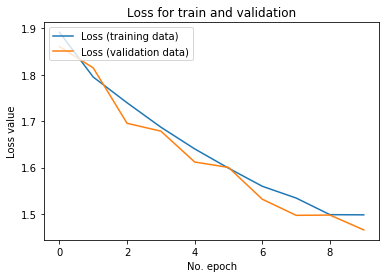

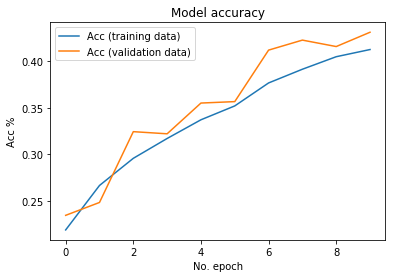

In [ ]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## **Validation Set Evaluation**

**Val Set Score**

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

41/41 - 16s - loss: 1.4658 - categorical_accuracy: 0.4312 - 16s/epoch - 380ms/step


**Val Set Confussion Matrix**

In [ ]:
# Validation Confusion matrix
import pandas as pd
y_val_class = np.argmax(y_val_class)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = emo
columns = emo
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

TypeError: Singleton array 0 cannot be considered a valid collection.

**Validation Set Predicted emotions accuracy**

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.3721
calm : 0.1500
happy : 0.3069
sad : 0.7196
angry : 0.4396
fearful : 0.2917
disgust : 0.5104


IndexError: list index out of range

## **Save & Load model, weights**


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = './model.json'
saved_weights_path = './model.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [ ]:
# Reading the model from JSON file

saved_model_path = './model.json'
saved_weights_path = './model.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, len(emo), dtype = 'int8')

**Test Set Score**

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

18/18 - 8s - loss: 1.4262 - categorical_accuracy: 0.4499 - 8s/epoch - 469ms/step


**Test Set Confussion Matrix**

Text(0.5, 51.0, 'Predicted emotion')

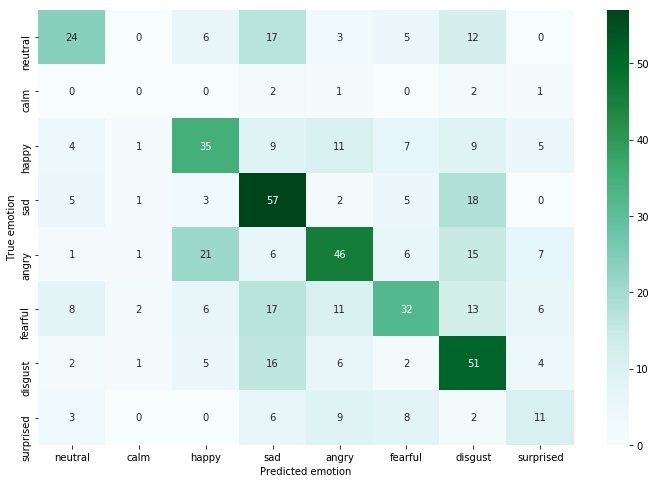

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")